In [1]:
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

Thu Jul  1 19:46:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!unzip -O cp949 '/content/drive/MyDrive/6nfood.zip' -d '/content/6food'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/6food/bibimbap/1001113.jpg  
  inflating: /content/6food/bibimbap/1002297.jpg  
  inflating: /content/6food/bibimbap/1004374.jpg  
  inflating: /content/6food/bibimbap/1004963.jpg  
  inflating: /content/6food/bibimbap/1006709.jpg  
  inflating: /content/6food/bibimbap/1007274.jpg  
  inflating: /content/6food/bibimbap/1009730.jpg  
  inflating: /content/6food/bibimbap/1011217.jpg  
  inflating: /content/6food/bibimbap/1014434.jpg  
  inflating: /content/6food/bibimbap/1016178.jpg  
  inflating: /content/6food/bibimbap/1018560.jpg  
  inflating: /content/6food/bibimbap/1021670.jpg  
  inflating: /content/6food/bibimbap/1025786.jpg  
  inflating: /content/6food/bibimbap/1035099.jpg  
  inflating: /content/6food/bibimbap/1036589.jpg  
  inflating: /content/6food/bibimbap/1039518.jpg  
  inflating: /content/6food/bibimbap/1039559.jpg  
  inflating: /content/6food/bibimbap/1045463.jpg  
  inflating: /content/6food/bibimbap/1045691.j

In [5]:
try:
    os.mkdir('/content/foods')
    os.mkdir('/content/foods/training')
    os.mkdir('/content/foods/testing')

    os.mkdir('/content/foods/training/churros')
    os.mkdir('/content/foods/training/hamburger')
    os.mkdir('/content/foods/training/pizza')
    os.mkdir('/content/foods/training/steak')
    os.mkdir('/content/foods/training/apple_pie')
    os.mkdir('/content/foods/training/bibimbap')

    os.mkdir('/content/foods/testing/churros')
    os.mkdir('/content/foods/testing/hamburger')
    os.mkdir('/content/foods/testing/pizza')
    os.mkdir('/content/foods/testing/steak')
    os.mkdir('/content/foods/testing/apple_pie')
    os.mkdir('/content/foods/testing/bibimbap')
except OSError:
    pass



In [6]:
import random
from shutil import copyfile

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

In [8]:
categories = ["apple_pie",'bibimbap','churros','hamburger','pizza','steak']

apple_pie_SOURCE_DIR = '/content/6food/apple_pie/'
TRAINING_apple_pie_DIR = '/content/foods/training/apple_pie/'
TESTING_apple_pie_DIR = '/content/foods/testing/apple_pie/'

bibimbap_SOURCE_DIR = '/content/6food/bibimbap/'
TRAINING_bibimbap_DIR = '/content/foods/training/bibimbap/'
TESTING_bibimbap_DIR = '/content/foods/testing/bibimbap/'

churros_SOURCE_DIR = '/content/6food/churros/'
TRAINING_churros_DIR = '/content/foods/training/churros/'
TESTING_churros_DIR = '/content/foods/testing/churros/'

hamburger_SOURCE_DIR = '/content/6food/hamburger/'
TRAINING_hamburger_DIR = '/content/foods/training/hamburger/'
TESTING_hamburger_DIR = '/content/foods/testing/hamburger/'

pizza_SOURCE_DIR = '/content/6food/pizza/'
TRAINING_pizza_DIR = '/content/foods/training/pizza/'
TESTING_pizza_DIR = '/content/foods/testing/pizza/'

steak_SOURCE_DIR = '/content/6food/steak/'
TRAINING_steak_DIR = '/content/foods/training/steak/'
TESTING_steak_DIR = '/content/foods/testing/steak/'

In [9]:
split_size = .9

split_data(apple_pie_SOURCE_DIR, TRAINING_apple_pie_DIR, TESTING_apple_pie_DIR, split_size)
split_data(bibimbap_SOURCE_DIR, TRAINING_bibimbap_DIR, TESTING_bibimbap_DIR, split_size)
split_data(churros_SOURCE_DIR, TRAINING_churros_DIR, TESTING_churros_DIR, split_size)
split_data(hamburger_SOURCE_DIR, TRAINING_hamburger_DIR, TESTING_hamburger_DIR, split_size)
split_data(pizza_SOURCE_DIR, TRAINING_pizza_DIR, TESTING_pizza_DIR, split_size)
split_data(steak_SOURCE_DIR, TRAINING_steak_DIR, TESTING_steak_DIR, split_size)

In [10]:
print("Number of training cat images", len(os.listdir('/content/foods/training/apple_pie/')))
print("Number of testing cat images", len(os.listdir('/content/foods/testing/apple_pie/')))

Number of training cat images 900
Number of testing cat images 100


In [11]:
TRAINING_DIR = "/content/foods/training/"

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='categorical',
                                                    target_size=(229, 229))

VALIDATION_DIR = "/content/foods/testing"

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='categorical',
                                                              target_size=(229, 229))

Found 5400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [12]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

# Model 초기화하기
pre_trained_model = InceptionV3(input_shape=(229, 229, 3),
                                include_top=False,
                                weights=None)

# pre-trained weights 가져오기
pre_trained_model.load_weights(weights_file)

# layer를 freeze하기
for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


#Output: last layer output shape: (None, 7, 7, 768)

last layer output shape:  (None, 12, 12, 768)


In [13]:
# 1 dimension의 output으로 flatten하기
x = layers.Flatten()(last_output)
# 1,024개의 hidden unit과 ReLU activation을 포함한 fully connected layer 추가
x = layers.Dense(128, activation='relu')(x)
# classification을 위한 마지막 sigmoid layer 추가하기
x = layers.Dense(6, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model_dir = './model'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_path = model_dir + '/multi_img_classification.model'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)

In [16]:
# model을 compile하기 
model.compile(optimizer=RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['acc'])

# model을 train하기 (epoch를 수정하며 성능 높이기)
history = model.fit(
            train_generator,
            validation_data=validation_generator,
            batch_size=64,
            epochs=50,
            verbose=1,
            callbacks = [checkpoint,early_stopping])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
54/54 [==============================] - 98s 1s/step - loss: 1.0290 - acc: 0.6376 - val_loss: 0.5647 - val_acc: 0.7900

Epoch 00001: val_loss improved from inf to 0.56474, saving model to ./model/multi_img_classification.model
INFO:tensorflow:Assets written to: ./model/multi_img_classification.model/assets
Epoch 2/50
54/54 [==============================] - 80s 1s/step - loss: 0.5661 - acc: 0.8091 - val_loss: 0.3613 - val_acc: 0.8917

Epoch 00002: val_loss improved from 0.56474 to 0.36130, saving model to ./model/multi_img_classification.model
INFO:tensorflow:Assets written to: ./model/multi_img_classification.model/assets
Epoch 3/50
54/54 [==============================] - 79s 1s/step - loss: 0.4839 - acc: 0.8352 - val_loss: 0.4955 - val_acc: 0.8317

Epoch 00003: val_loss did not improve from 0.36130
Epoch 4/50
54/54 [==============================] - 78s 1s/step - loss: 0.4450 - acc: 0.8467 - val_loss: 0.3805 - val_acc: 0.8650

Epoch 00004: val_loss did not improve from 0.

<Figure size 432x288 with 0 Axes>

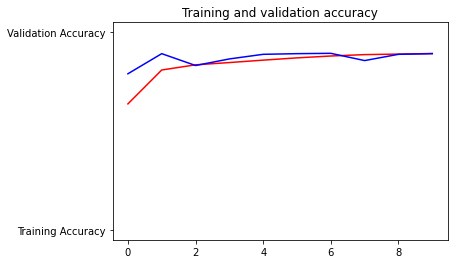

<Figure size 432x288 with 0 Axes>

In [17]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#training과 test data에 result를 추출하기
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # epochs 수 확인

#각 epoch마다 training과 validation accuracy 확인
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

In [24]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # image 예측하기
  path = '/content/' + fn
  img = image.load_img(path, target_size=(229, 229))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)

  np.argmax(classes)

  print(classes)

  if classes[0][0]>0.5:
    print(fn + " a")
  elif classes[0][1]>0.5:
    print(fn + " b")
  elif classes[0][2]>0.5:
    print(fn + " c")
  elif classes[0][3]>0.5:
    print(fn + " h")
  elif classes[0][4]>0.5:
    print(fn + " p")  
  else:
    print(fn + " s")

Saving a1.jpg to a1.jpg
[[0.0000000e+00 4.7659361e-28 3.2875532e-15 1.3830687e-26 0.0000000e+00
  1.0000000e+00]]
a1.jpg s
